<a href="https://colab.research.google.com/github/ElisabethShah/DS-Unit-2-Linear-Models/blob/master/DS_Sprint_Challenge_5_Linear_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Linear Models  Sprint Challenge: Predict home prices in Ames, Iowa 🏠💸

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

For your Sprint Challenge, you'll use historical housing data. There's a data dictionary at the bottom of the notebook. 

Run this code cell to load the dataset:





In [1]:
# Install package(s).
!pip install category_encoders

In [0]:
# Import libraries.
import category_encoders as ce
import matplotlib.pyplot as plt
import pandas as pd
import pandas_profiling as pp
import numpy as np

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import OrdinalEncoder

In [0]:
# Set display option(s).
%matplotlib inline

In [0]:
# Load data.
URL = ('https://drive.google.com/uc?export=download&'
       'id=1522WlEW6HFss36roD_Cd9nybqSuiVcCK')
df = pd.read_csv(URL)
assert df.shape == (2904, 47)

In [0]:
# Define helper functions.
def print_parameters(model, features):
    print(f'Intercept: {model.intercept_}')
    print(pd.Series(model.coef_, features))

def print_metrics(y_train, y_train_pred, y_test, y_pred):
    print(f'Train MAE: {mean_absolute_error(y_train, y_train_pred)}')
    print(f'Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred))}')
    print(f'Train R2: {r2_score(y_train, y_train_pred)}')
    print()
    print(f'Test MAE: {mean_absolute_error(y_test, y_pred)}')
    print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
    print(f'Test R2: {r2_score(y_test, y_pred)}')

def evaluate_featureset(features, target, train, test):
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    model.fit(X_train, y_train)
    y_train_pred
    y_pred = model.predict(X_test)
    
    print_parameters(model, features)
    print()
    print_metrics(y_train, y_train_pred, y_test, y_pred)

## 1. Do train/test split
Train on houses sold in the years 2006 - 2008. Test on houses sold in the years 2009 - 2010.

In [6]:
# Examine the variable on which we will split.
df['Yr_Sold'].value_counts().sort_index()

2006    621
2007    686
2008    613
2009    644
2010    340
Name: Yr_Sold, dtype: int64

In [0]:
# Split data. We make explicit copies here to avoid warnings later.
train = df.query('Yr_Sold < 2009').copy()
test = df.query('Yr_Sold >= 2009').copy()

y_train = train['SalePrice']
y_test = test['SalePrice']

In [8]:
# Verify split.
train.shape, test.shape

((1920, 47), (984, 47))

## 2. Begin with baselines

What is the Mean Absolute Error and R^2 score for a mean baseline?

In [9]:
# Find mean sale price for training data.
train_mean = y_train.mean()
print(train_mean)

181515.98645833333


In [10]:
# Make and evaluate simple mean-based prediction.
y_train_pred = np.full_like(y_train, fill_value=train_mean)
y_pred = np.full_like(y_test, fill_value=train_mean)

print_metrics(y_train, y_train_pred, y_test, y_pred)

Train MAE: 58502.703125
Train RMSE: 80200.88358638238
Train R2: -1.5128609476278143e-10

Test MAE: 58276.60467479675
Test RMSE: 79003.29449829513
Test R2: -0.001791240523888682


In [11]:
# Calculate and print standard deviation for comparison.
print(y_train.std())

80221.77738908003


## 3. Arrange data into X features matrix and y target vector
Select at least one numeric feature and at least one categorical feature.

In [12]:
# Explore training dataset generally.
pp.ProfileReport(train)

Number of variables,48
Number of observations,1920
Total Missing (%),0.0%
Total size in memory,720.1 KiB
Average record size in memory,384.0 B
Numeric,19
Categorical,29
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [13]:
# Explore numeric features.
train.corr().sort_values(by='SalePrice')

,1st_Flr_SF,Bedroom_AbvGr,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Gr_Liv_Area,Half_Bath,Kitchen_AbvGr,Lot_Area,MS_SubClass,Mo_Sold,Overall_Cond,Overall_Qual,SalePrice,TotRms_AbvGrd,Year_Built,Year_Remod/Add,Yr_Sold
Kitchen_AbvGr,0.091412,0.202733,-0.025911,-0.079958,0.145074,0.080595,-0.073243,1.000000,-0.015334,0.251845,0.034964,-0.066324,-0.152809,-0.116364,0.264052,-0.137484,-0.136148,0.017116
Overall_Cond,-0.164504,-0.005724,-0.043767,0.074395,-0.208326,-0.113623,-0.086568,-0.066324,-0.048727,-0.065811,-0.023102,1.000000,-0.117917,-0.112676,-0.069893,-0.403884,0.011486,0.087433
MS_SubClass,-0.208174,-0.026119,0.048769,-0.013589,0.133444,0.070994,0.142293,0.251845,-0.184853,1.000000,0.004942,-0.065811,0.060124,-0.056974,0.031975,0.044797,0.057880,-0.011769
Bsmt_Half_Bath,0.022266,0.031316,-0.151471,1.000000,-0.043460,-0.032522,-0.054021,-0.079958,0.041289,-0.013589,0.009239,0.074395,-0.033545,-0.023940,-0.041915,-0.019288,-0.038891,0.006410
Yr_Sold,-0.009871,-0.006329,0.020572,0.006410,0.001762,-0.015123,-0.003929,0.017116,-0.003829,-0.011769,-0.027621,0.087433,0.009208,-0.011586,-0.028137,-0.024170,0.060407,1.000000
Mo_Sold,0.062930,0.059517,0.009522,0.009239,0.082476,0.052355,0.003221,0.034964,0.004947,0.004942,1.000000,-0.023102,0.049602,0.055862,0.057370,0.046806,0.049453,-0.027621
Bedroom_AbvGr,0.105116,1.000000,-0.181895,0.031316,0.350338,0.501463,0.245134,0.202733,0.139207,-0.026119,0.059517,-0.005724,0.063614,0.156566,0.674635,-0.061325,-0.020749,-0.006329
Lot_Area,0.344041,0.139207,0.113893,0.041289,0.134673,0.302276,0.051122,-0.015334,1.000000,-0.184853,0.004947,-0.048727,0.090429,0.256760,0.219181,0.016992,0.022375,-0.003829
Bsmt_Full_Bath,0.258932,-0.181895,1.000000,-0.151471,-0.040492,0.055249,-0.046440,-0.025911,0.113893,0.048769,0.009522,-0.043767,0.162674,0.267121,-0.043133,0.214395,0.129021,0.020572
Half_Bath,-0.089321,0.245134,-0.046440,-0.054021,0.153112,0.443564,1.000000,-0.073243,0.051122,0.142293,0.003221,-0.086568,0.284389,0.300418,0.373942,0.271524,0.222792,-0.003929


In [14]:
# Explore categorical features.
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
Utilities,1920,2,AllPub,1919
Central_Air,1920,2,Y,1791
Street,1920,2,Pave,1912
Paved_Drive,1920,3,Y,1731
Land_Slope,1920,3,Gtl,1829
Lot_Shape,1920,4,Reg,1203
Land_Contour,1920,4,Lvl,1716
Kitchen_Qual,1920,4,TA,991
Exter_Qual,1920,4,TA,1197
Bldg_Type,1920,5,1Fam,1588


In [0]:
# Select features and target.
features = ['Overall_Qual', 'Neighborhood']
target = 'SalePrice'

In [0]:
# Split feature matrices and target vectors (partially redundant with baseline 
# model code).
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

## 4. Do one-hot encoding

Encode your categorical feature(s).

In [0]:
# Build and run encoder.
onehot_encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = onehot_encoder.fit_transform(train[features])
X_test = onehot_encoder.transform(test[features])

In [18]:
# Check encoder output.
X_train.head()

,Overall_Qual,Neighborhood_NAmes,Neighborhood_Gilbert,Neighborhood_StoneBr,Neighborhood_NWAmes,Neighborhood_BrDale,Neighborhood_NPkVill,Neighborhood_NridgHt,Neighborhood_Blmngtn,Neighborhood_NoRidge,Neighborhood_Somerst,Neighborhood_SawyerW,Neighborhood_Sawyer,Neighborhood_Veenker,Neighborhood_BrkSide,Neighborhood_OldTown,Neighborhood_IDOTRR,Neighborhood_ClearCr,Neighborhood_Edwards,Neighborhood_CollgCr,Neighborhood_SWISU,Neighborhood_Crawfor,Neighborhood_Blueste,Neighborhood_Mitchel,Neighborhood_Timber,Neighborhood_MeadowV,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_Landmrk
984,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
985,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
986,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
987,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
988,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 5. Do ordinal encoding

Encode more categorical feature(s).

### Preview features to be encoded

In [19]:
train['Exter_Cond'].value_counts()

TA    1683
Gd     187
Fa      41
Ex       8
Po       1
Name: Exter_Cond, dtype: int64

In [20]:
train['Exter_Qual'].value_counts()

TA    1197
Gd     642
Ex      64
Fa      17
Name: Exter_Qual, dtype: int64

In [21]:
train['Kitchen_Qual'].value_counts()

TA    991
Gd    758
Ex    127
Fa     44
Name: Kitchen_Qual, dtype: int64

In [22]:
train['Heating_QC'].value_counts()

Ex    976
TA    550
Gd    332
Fa     59
Po      3
Name: Heating_QC, dtype: int64

### Encode features

In [0]:
ordinal_encoder = OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex']])

train['Exter_Cond'] = ordinal_encoder.fit_transform(train['Exter_Cond'].values.reshape(-1,1))
train['Exter_Qual'] = ordinal_encoder.fit_transform(train['Exter_Qual'].values.reshape(-1,1))
train['Kitchen_Qual'] = ordinal_encoder.fit_transform(train['Kitchen_Qual'].values.reshape(-1,1))
train['Heating_QC'] = ordinal_encoder.fit_transform(train['Heating_QC'].values.reshape(-1,1))

### Review encoded features

In [24]:
train['Exter_Cond'].value_counts()

2.0    1683
3.0     187
1.0      41
4.0       8
0.0       1
Name: Exter_Cond, dtype: int64

In [25]:
train['Kitchen_Qual'].value_counts()

2.0    991
3.0    758
4.0    127
1.0     44
Name: Kitchen_Qual, dtype: int64

In [26]:
train['Heating_QC'].value_counts()

4.0    976
2.0    550
3.0    332
1.0     59
0.0      3
Name: Heating_QC, dtype: int64

### Apply encoding to test features

In [0]:
test['Exter_Cond'] = ordinal_encoder.fit_transform(test['Exter_Cond'].values.reshape(-1,1))
test['Exter_Qual'] = ordinal_encoder.fit_transform(test['Exter_Qual'].values.reshape(-1,1))
test['Kitchen_Qual'] = ordinal_encoder.fit_transform(test['Kitchen_Qual'].values.reshape(-1,1))
test['Heating_QC'] = ordinal_encoder.fit_transform(test['Heating_QC'].values.reshape(-1,1))

## 6. Use scikit-learn for Linear Regression
Fit your model.

In [28]:
# Build model. Set fit_intercept to false to make coefficients play nicely with 
# one-hot encoding.
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [0]:
# Make predictions.
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

## 7. Use regression metrics: MAE, RMSE, R^2
What are the Mean Absolute Error, Root Mean Squared Error and R^2 score for your model? ***Beat the mean baseline!***

In [30]:
print_metrics(y_train, y_train_pred, y_test, y_pred)

Train MAE: 28437.45143059483
Train RMSE: 42037.761457991604
Train R2: 0.7252606559662899

Test MAE: 28835.80885498872
Test RMSE: 41134.39166660851
Test R2: 0.7284205004468856


## 8. Get coefficients of a linear model
Print or plot the coefficients for the features in your model.

In [31]:
# Print coefficients.
print(f'Intercept: {model.intercept_}')
pd.Series(model.coef_, X_train.columns).sort_values(ascending=False)

Intercept: 0.0


Neighborhood_NoRidge    79989.961115
Neighborhood_StoneBr    55518.992713
Neighborhood_GrnHill    51692.608639
Neighborhood_NridgHt    49306.027764
Overall_Qual            32615.341623
Neighborhood_Veenker    15616.074477
Neighborhood_Timber     13829.982603
Neighborhood_ClearCr    13307.994154
Neighborhood_Crawfor     3000.375725
Neighborhood_Somerst   -14356.091564
Neighborhood_CollgCr   -15203.219902
Neighborhood_NWAmes    -18581.930998
Neighborhood_SawyerW   -19919.901237
Neighborhood_Mitchel   -19999.396794
Neighborhood_Gilbert   -21342.582028
Neighborhood_Sawyer    -27843.162952
Neighborhood_Blmngtn   -28653.342605
Neighborhood_NAmes     -29591.244250
Neighborhood_Edwards   -35024.439079
Neighborhood_SWISU     -40255.033401
Neighborhood_OldTown   -44058.125308
Neighborhood_BrkSide   -44526.677060
Neighborhood_MeadowV   -46607.130471
Neighborhood_IDOTRR    -50431.054365
Neighborhood_Landmrk   -58692.049738
Neighborhood_NPkVill   -63808.274724
Neighborhood_Blueste   -64149.720550
N

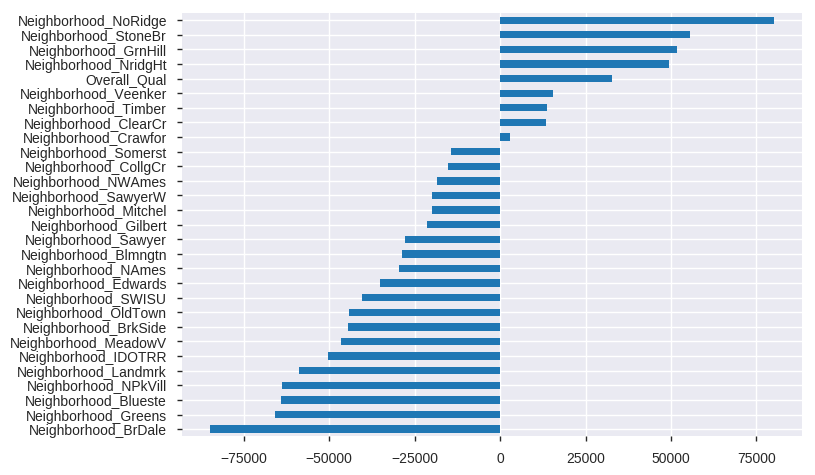

In [32]:
# Plot coefficients.
coefs = pd.Series(model.coef_, X_train.columns)
coefs.sort_values().plot.barh();

## Stretch Goals
- Try at least 3 different feature combinations.
- Plot exploratory visualizations.
- Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.

### Experiment with different featuresets

In [33]:
# Re-run profile report.
pp.ProfileReport(train)

Number of variables,48
Number of observations,1920
Total Missing (%),0.0%
Total size in memory,720.1 KiB
Average record size in memory,384.0 B
Numeric,23
Categorical,25
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [34]:
# Re-explore numeric features.
train.corr().sort_values(by='SalePrice')

,1st_Flr_SF,Bedroom_AbvGr,Bsmt_Full_Bath,Bsmt_Half_Bath,Exter_Cond,Exter_Qual,Full_Bath,Gr_Liv_Area,Half_Bath,Heating_QC,Kitchen_AbvGr,Kitchen_Qual,Lot_Area,MS_SubClass,Mo_Sold,Overall_Cond,Overall_Qual,SalePrice,TotRms_AbvGrd,Year_Built,Year_Remod/Add,Yr_Sold
Kitchen_AbvGr,0.091412,0.202733,-0.025911,-0.079958,-0.030381,-0.142822,0.145074,0.080595,-0.073243,-0.142831,1.000000,-0.169005,-0.015334,0.251845,0.034964,-0.066324,-0.152809,-0.116364,0.264052,-0.137484,-0.136148,0.017116
Overall_Cond,-0.164504,-0.005724,-0.043767,0.074395,0.361732,-0.201509,-0.208326,-0.113623,-0.086568,-0.010693,-0.066324,-0.085933,-0.048727,-0.065811,-0.023102,1.000000,-0.117917,-0.112676,-0.069893,-0.403884,0.011486,0.087433
MS_SubClass,-0.208174,-0.026119,0.048769,-0.013589,-0.053962,0.044549,0.133444,0.070994,0.142293,0.009725,0.251845,0.003875,-0.184853,1.000000,0.004942,-0.065811,0.060124,-0.056974,0.031975,0.044797,0.057880,-0.011769
Bsmt_Half_Bath,0.022266,0.031316,-0.151471,1.000000,0.014082,-0.055227,-0.043460,-0.032522,-0.054021,-0.069696,-0.079958,-0.042072,0.041289,-0.013589,0.009239,0.074395,-0.033545,-0.023940,-0.041915,-0.019288,-0.038891,0.006410
Yr_Sold,-0.009871,-0.006329,0.020572,0.006410,0.022775,0.010449,0.001762,-0.015123,-0.003929,0.031539,0.017116,0.017906,-0.003829,-0.011769,-0.027621,0.087433,0.009208,-0.011586,-0.028137,-0.024170,0.060407,1.000000
Exter_Cond,-0.008324,0.017852,0.026561,0.014082,1.000000,0.018395,0.016162,0.029883,-0.011366,0.089400,-0.030381,0.042592,-0.000027,-0.053962,0.011037,0.361732,0.011762,0.031243,0.013484,-0.092474,0.073026,0.022775
Mo_Sold,0.062930,0.059517,0.009522,0.009239,0.011037,0.062168,0.082476,0.052355,0.003221,0.015335,0.034964,0.068383,0.004947,0.004942,1.000000,-0.023102,0.049602,0.055862,0.057370,0.046806,0.049453,-0.027621
Bedroom_AbvGr,0.105116,1.000000,-0.181895,0.031316,0.017852,-0.049839,0.350338,0.501463,0.245134,-0.018027,0.202733,-0.027351,0.139207,-0.026119,0.059517,-0.005724,0.063614,0.156566,0.674635,-0.061325,-0.020749,-0.006329
Lot_Area,0.344041,0.139207,0.113893,0.041289,-0.000027,0.058468,0.134673,0.302276,0.051122,0.014410,-0.015334,0.083835,1.000000,-0.184853,0.004947,-0.048727,0.090429,0.256760,0.219181,0.016992,0.022375,-0.003829
Bsmt_Full_Bath,0.258932,-0.181895,1.000000,-0.151471,0.026561,0.152989,-0.040492,0.055249,-0.046440,0.080307,-0.025911,0.158530,0.113893,0.048769,0.009522,-0.043767,0.162674,0.267121,-0.043133,0.214395,0.129021,0.020572


In [0]:
# Re-initialize model. Without the 'extra' feature from one-hot encoding, we'll 
# want our intercept back.
model = LinearRegression()

In [36]:
# One-feature regression.
features = ['Overall_Qual']
evaluate_featureset(features, target, train, test)

Intercept: -97019.341212728
Overall_Qual    45634.254555
dtype: float64

Train MAE: 28437.45143059483
Train RMSE: 42037.761457991604
Train R2: 0.7252606559662899

Test MAE: 33493.74378954229
Test RMSE: 46851.513972059714
Test R2: 0.647682606336063


In [37]:
# One-feature regression (alternate).
features = ['Gr_Liv_Area']
evaluate_featureset(features, target, train, test)

Intercept: 15978.590432651981
Gr_Liv_Area    110.062281
dtype: float64

Train MAE: 28437.45143059483
Train RMSE: 42037.761457991604
Train R2: 0.7252606559662899

Test MAE: 40395.62957205254
Test RMSE: 57365.456418625414
Test R2: 0.47181297016171797


In [38]:
# Two-feature regression.
features = ['Overall_Qual',
            'Gr_Liv_Area']
evaluate_featureset(features, target, train, test)

Intercept: -106414.38948827836
Overall_Qual    32757.561940
Gr_Liv_Area        58.502552
dtype: float64

Train MAE: 28437.45143059483
Train RMSE: 42037.761457991604
Train R2: 0.7252606559662899

Test MAE: 29039.772010173016
Test RMSE: 40624.97398813402
Test R2: 0.7351054533421586


In [39]:
# Three-feature regression.
features = ['Overall_Qual',
            'Gr_Liv_Area',
            '1st_Flr_SF']
evaluate_featureset(features, target, train, test)

Intercept: -117043.58965211682
Overall_Qual    30565.863437
Gr_Liv_Area        46.242551
1st_Flr_SF         36.628736
dtype: float64

Train MAE: 28437.45143059483
Train RMSE: 42037.761457991604
Train R2: 0.7252606559662899

Test MAE: 26607.567997981234
Test RMSE: 37387.53959451111
Test R2: 0.7756424970534259


In [40]:
# Four-feature regression.
features = ['Overall_Qual',
            'Gr_Liv_Area',
            '1st_Flr_SF',
            'Exter_Qual']
evaluate_featureset(features, target, train, test)

Intercept: -132141.8589227812
Overall_Qual    22799.489948
Gr_Liv_Area        46.533652
1st_Flr_SF         33.937936
Exter_Qual      27247.772872
dtype: float64

Train MAE: 28437.45143059483
Train RMSE: 42037.761457991604
Train R2: 0.7252606559662899

Test MAE: 25231.023855711963
Test RMSE: 35029.59761043417
Test R2: 0.8030494840286843


In [41]:
# Five-feature regression.
features = ['Overall_Qual',
            'Gr_Liv_Area',
            '1st_Flr_SF',
            'Exter_Qual',
            'Kitchen_Qual']
evaluate_featureset(features, target, train, test)

Intercept: -136483.78792941163
Overall_Qual    20443.313873
Gr_Liv_Area        45.674711
1st_Flr_SF         33.124173
Exter_Qual      18208.243142
Kitchen_Qual    17004.588321
dtype: float64

Train MAE: 28437.45143059483
Train RMSE: 42037.761457991604
Train R2: 0.7252606559662899

Test MAE: 24773.351697000977
Test RMSE: 34267.316049485766
Test R2: 0.8115279275777656


In [42]:
# Six-feature regression.
features = ['Overall_Qual',
            'Gr_Liv_Area',
            '1st_Flr_SF',
            'Exter_Qual',
            'Kitchen_Qual',
            'Full_Bath']
evaluate_featureset(features, target, train, test)

Intercept: -136355.0223204883
Overall_Qual    20498.425876
Gr_Liv_Area        46.331294
1st_Flr_SF         33.052247
Exter_Qual      18425.692013
Kitchen_Qual    17014.778506
Full_Bath       -1226.431344
dtype: float64

Train MAE: 28437.45143059483
Train RMSE: 42037.761457991604
Train R2: 0.7252606559662899

Test MAE: 24777.352597679022
Test RMSE: 34250.08155223056
Test R2: 0.8117174612182464


In [43]:
# Seven-feature regression.
features = ['Overall_Qual',
            'Gr_Liv_Area',
            '1st_Flr_SF',
            'Exter_Qual',
            'Kitchen_Qual',
            'Full_Bath',
            'Year_Built']
evaluate_featureset(features, target, train, test)

Intercept: -716004.6058035224
Overall_Qual    18636.641414
Gr_Liv_Area        52.847884
1st_Flr_SF         30.688318
Exter_Qual      13563.805561
Kitchen_Qual    15102.947739
Full_Bath       -6361.228556
Year_Built        308.664383
dtype: float64

Train MAE: 28437.45143059483
Train RMSE: 42037.761457991604
Train R2: 0.7252606559662899

Test MAE: 23547.83551124503
Test RMSE: 33211.82691043926
Test R2: 0.8229596100427886


In [44]:
# Ten-feature regression.
features = ['Overall_Qual',
            'Gr_Liv_Area',
            '1st_Flr_SF',
            'Exter_Qual',
            'Kitchen_Qual',
            'Full_Bath',
            'Year_Built',
            'Year_Remod/Add',
            'TotRms_AbvGrd',
            'Heating_QC']
evaluate_featureset(features, target, train, test)

Intercept: -767977.2067298617
Overall_Qual      18408.012534
Gr_Liv_Area          57.784271
1st_Flr_SF           31.045069
Exter_Qual        12090.311425
Kitchen_Qual      13632.962151
Full_Bath         -6397.288358
Year_Built          282.249048
Year_Remod/Add       55.438794
TotRms_AbvGrd     -1963.962180
Heating_QC         2398.404958
dtype: float64

Train MAE: 28437.45143059483
Train RMSE: 42037.761457991604
Train R2: 0.7252606559662899

Test MAE: 23459.46520443777
Test RMSE: 33248.32370029005
Test R2: 0.8225702935396795


In [45]:
# And back down to eight features.
features = ['Overall_Qual',
            'Gr_Liv_Area',
            '1st_Flr_SF',
            'Exter_Qual',
            'Kitchen_Qual',
            'Full_Bath',
            'Year_Built',
            'Lot_Area']
evaluate_featureset(features, target, train, test)

Intercept: -720534.9154722572
Overall_Qual    19279.081063
Gr_Liv_Area        49.882444
1st_Flr_SF         26.364342
Exter_Qual      14095.679983
Kitchen_Qual    14939.774631
Full_Bath       -5852.219845
Year_Built        309.135008
Lot_Area            0.730542
dtype: float64

Train MAE: 28437.45143059483
Train RMSE: 42037.761457991604
Train R2: 0.7252606559662899

Test MAE: 22834.081565248976
Test RMSE: 32296.3862838099
Test R2: 0.8325848765180341


## Data Dictionary 

Here's a description of the data fields:

```
1st_Flr_SF: First Floor square feet

Bedroom_AbvGr: Bedrooms above grade (does NOT include basement bedrooms)

Bldg_Type: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit
       
Bsmt_Half_Bath: Basement half bathrooms

Bsmt_Full_Bath: Basement full bathrooms

Central_Air: Central air conditioning

       N	No
       Y	Yes
		
Condition_1: Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
Condition_2: Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
       
 Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed
       
 Exter_Cond: Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
 
 Exter_Qual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
Exterior_1st: Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
Exterior_2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
       
Foundation: Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood
		
Full_Bath: Full bathrooms above grade

Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only
		
Gr_Liv_Area: Above grade (ground) living area square feet
        
Half_Bath: Half baths above grade

Heating: Type of heating
		
       Floor	Floor Furnace
       GasA	Gas forced warm air furnace
       GasW	Gas hot water or steam heat
       Grav	Gravity furnace	
       OthW	Hot water or steam heat other than gas
       Wall	Wall furnace
		
Heating_QC: Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

House_Style: Style of dwelling
	
       1Story	One story
       1.5Fin	One and one-half story: 2nd level finished
       1.5Unf	One and one-half story: 2nd level unfinished
       2Story	Two story
       2.5Fin	Two and one-half story: 2nd level finished
       2.5Unf	Two and one-half story: 2nd level unfinished
       SFoyer	Split Foyer
       SLvl	Split Level

Kitchen_AbvGr: Kitchens above grade

Kitchen_Qual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

LandContour: Flatness of the property

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression
		
Land_Slope: Slope of property
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope

Lot_Area: Lot size in square feet

Lot_Config: Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property

Lot_Shape: General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular

MS_SubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MS_Zoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

Mas_Vnr_Type: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone

Mo_Sold: Month Sold (MM)

Neighborhood: Physical locations within Ames city limits

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker
			
Overall_Cond: Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor

Overall_Qual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor

Paved_Drive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel

Roof_Matl: Roof material

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles

Roof_Style: Type of roof

       Flat	Flat
       Gable	Gable
       Gambrel	Gabrel (Barn)
       Hip	Hip
       Mansard	Mansard
       Shed	Shed

SalePrice: the sales price for each house

Sale_Condition: Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)

Sale_Type: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
	
Street: Type of road access to property

       Grvl	Gravel	
       Pave	Paved
       	
TotRms_AbvGrd: Total rooms above grade (does not include bathrooms)

Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only	
	
Year_Built: Original construction date

Year_Remod/Add: Remodel date (same as construction date if no remodeling or additions)
						
Yr_Sold: Year Sold (YYYY)	

```